In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

sys.path.append(os.path.join(os.path.dirname(""), os.pardir))
import coherence_analysis.utils as f

In [2]:
# generate 2d array of i.i.d. samples from a normal distribution
def generate_samples(n, m, mean=0, std=1):
    """
    Generate a 2D array of i.i.d. samples from a normal distribution.

    Parameters:
    n (int): Number of rows.
    m (int): Number of columns.
    mean (float): Mean of the normal distribution.
    std (float): Standard deviation of the normal distribution.

    Returns:
    np.ndarray: 2D array of samples.
    """
    return np.random.normal(mean, std, size=(n, m))

def get_coherence_data(event_file_groups, basepath, group_index = -1, start_channel=0, end_channel=1000, num_sensors=1, end_sample=-1):

    file = basepath / event_file_groups[group_index][0]
    data, _ = f.load_brady_hdf5(file, normalize="no")
    print(f"Loading {file}")
    for a in range(1, len(event_file_groups[group_index]) - 1):
        file = basepath / event_file_groups[group_index][a]
        print(f"Loading {file}")
        data2, _ = f.load_brady_hdf5(file, normalize="no")
        data = np.append(data, data2, axis=1)

    file = basepath / event_file_groups[group_index][-1]
    print(f"Loading {file}")
    data2, _ = f.load_brady_hdf5(file, normalize="no")

    if end_sample == -1:
        data = np.append(data, data2, axis=1)
    else:
        data = np.append(data, data2[:, :end_sample], axis=1)
    coherence_data = data[start_channel : end_channel : int((end_channel - start_channel) / num_sensors)]
    
    return coherence_data

In [3]:
win_len = 2
overlap = 0
samples_per_sec = 1000

nsensors = 200

data = generate_samples(nsensors, 70000, mean=0, std=0.01)

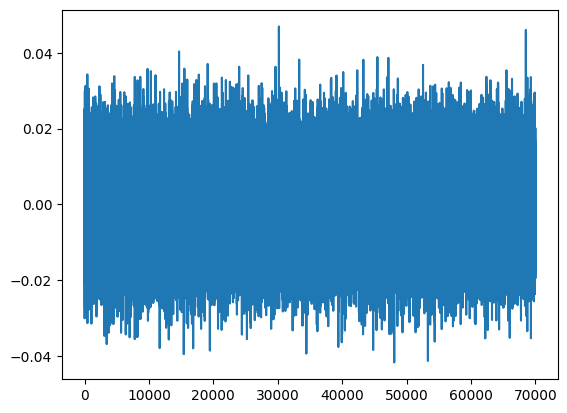

In [4]:
plt.plot(data[0, :])

In [5]:
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    data, win_len, overlap, sample_interval=1 / samples_per_sec
)

In [6]:
num_frames = norm_win_spectra.shape[0]
sim_eig_ratios_coherence = np.empty(num_frames)
sim_eig_ratios_coherence_qr = np.empty(num_frames)

for d in range(1,num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
            norm_win_spectra[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    sim_eig_ratios_coherence[d] = np.max(svd_approx2) / np.sum(svd_approx2)

    Q, R = np.linalg.qr(norm_win_spectra[d])
    # RRH = R @ (np.matrix(R).H)
    # diag is of sqrt(RR^*)
    # qr_approx2 = np.power(np.diag(RRH), 1)
    qr_approx2 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
    sim_eig_ratios_coherence_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)

Text(0, 0.5, 'QR')

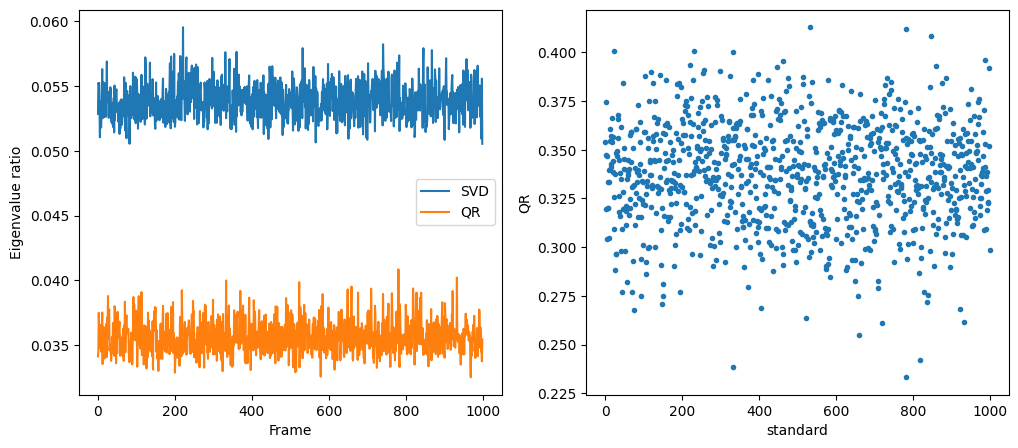

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(
    sim_eig_ratios_coherence[1:],
    label="SVD",
)
plt.plot(
    sim_eig_ratios_coherence_qr[1:],
    label="QR",
)
plt.xlabel("Frame")
plt.ylabel("Eigenvalue ratio")
# plt.title("Eigenvalue ratio of coherence matrix")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot((sim_eig_ratios_coherence[1:] - sim_eig_ratios_coherence_qr[1:])/sim_eig_ratios_coherence[1:], ".")
# plt.plot((eig_ratios_coherence[1:] - eig_ratios_coherence_qr[1:]), ".")
plt.xlabel("standard")
plt.ylabel("QR")

<Axes: ylabel='Density'>

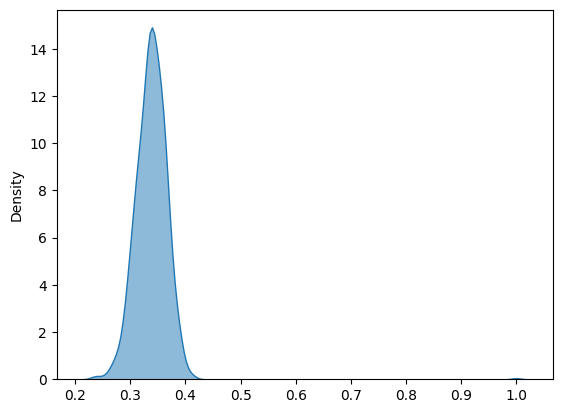

In [8]:
sns.kdeplot((sim_eig_ratios_coherence - sim_eig_ratios_coherence_qr)/sim_eig_ratios_coherence, fill=True, alpha=0.5)

In [9]:
# threshold_u = 0.3
# threshold_d = 0.1

# max_norms_events, other_norms_events, max_norms_noise, other_norms_noise = get_norm_parameters(
#     eig_ratios_coherence, norm_win_spectra, threshold_u, threshold_d, qr=False
# )
# ratios_events = np.array(max_norms_events) / np.array(other_norms_events)
# ratios_noise = np.array(max_norms_noise) / np.array(other_norms_noise)

# plt.figure(figsize=(16, 5))
# plt.subplot(1, 3, 1)
# plt.plot(max_norms_events, other_norms_events, "o--", label="events")
# plt.plot(max_norms_noise, other_norms_noise, "o--", label="noise", alpha=0.5)
# plt.title("Events")
# plt.xlabel("Max norm")
# plt.ylabel("Other norms")
# plt.legend()
# plt.subplot(1, 3, 2)
# plt.plot(max_norms_noise, other_norms_noise, "o--")
# plt.title("Noise")
# plt.xlabel("Max norm")
# plt.ylabel("Other norms")
# plt.subplot(1, 3, 3)

In [94]:
start_channel = 1300
end_channel = 3300

In [35]:
basepath = Path("D:\CSM\Mines_Research\Test_data\Brady Hotspring")
files = ["PoroTomo_iDAS16043_160314083818.h5", "PoroTomo_iDAS16043_160314083848.h5", "PoroTomo_iDAS16043_160314083918.h5"]
file = basepath / files[1]

real_data, _ = f.load_brady_hdf5(file, normalize="no")
real_data = real_data[start_channel : end_channel : int((end_channel - start_channel) / nsensors)]

In [95]:
file = basepath / files[0]
print(f"Loading {file}")
real_data, _ = f.load_brady_hdf5(file, normalize="no")
real_data = real_data[start_channel : end_channel : int((end_channel - start_channel) / nsensors)]

file = basepath / files[1]
print(f"Loading {file}")
data2, _ = f.load_brady_hdf5(file, normalize="no")
data2 = data2[start_channel : end_channel : int((end_channel - start_channel) / nsensors)]
real_data = np.append(real_data, data2, axis=1)

file = basepath / files[2]
print(f"Loading {file}")
data2, _ = f.load_brady_hdf5(file, normalize="no")
data2 = data2[start_channel : end_channel : int((end_channel - start_channel) / nsensors)]
real_data = np.append(real_data, data2[:, :10000], axis=1)

Loading D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083818.h5
Loading D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5
Loading D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5


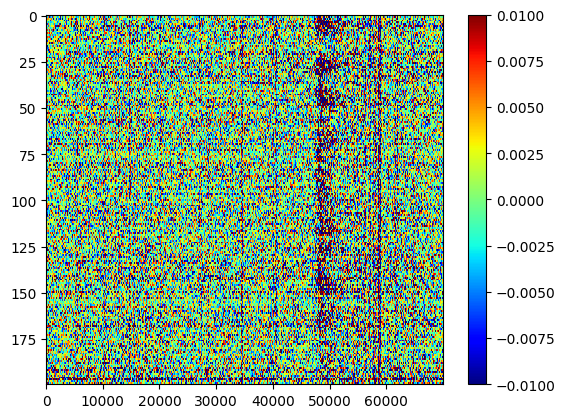

In [96]:
plt.imshow(
    real_data,
    aspect="auto",
    interpolation="none",
    cmap="jet",
    vmin=-0.01,
    vmax=0.01,
    # extent=[0, 70000, 0, nsensors],
)
plt.colorbar()

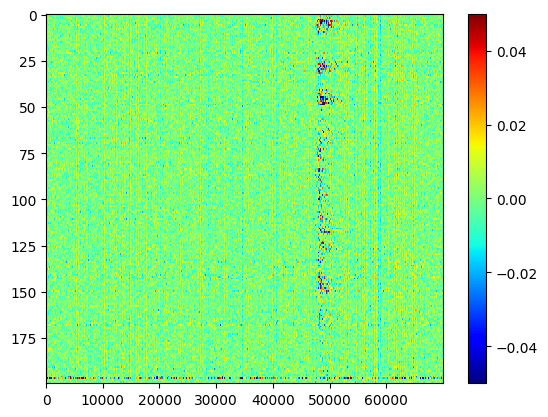

In [97]:
# data[:, 15000:25000] = data[:, 15000:25000] + real_data[:, 15000:25000]

plt.imshow(
    real_data,
    aspect="auto",
    interpolation="none",
    cmap="jet",
    vmin=-0.05,
    vmax=0.05,
    # extent=[0, 70000, 0, nsensors],
)
plt.colorbar()

In [98]:
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    real_data, win_len, overlap, sample_interval=1 / samples_per_sec
)

In [99]:
num_frames = norm_win_spectra.shape[0]
eig_ratios_coherence = np.empty(num_frames)
eig_ratios_coherence_qr = np.empty(num_frames)

for d in range(1,num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
            norm_win_spectra[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_coherence[d] = np.max(svd_approx2) / np.sum(svd_approx2)

    Q, R = np.linalg.qr(norm_win_spectra[d])
    # RRH = R @ (np.matrix(R).H)
    # diag is of sqrt(RR^*)
    # qr_approx2 = np.power(np.diag(RRH), 1)
    qr_approx2 = np.sum(np.multiply(R, np.conjugate(R)).real, axis=1)
    eig_ratios_coherence_qr[d] = np.max(qr_approx2) / np.sum(qr_approx2)

Text(0, 0.5, 'QR')

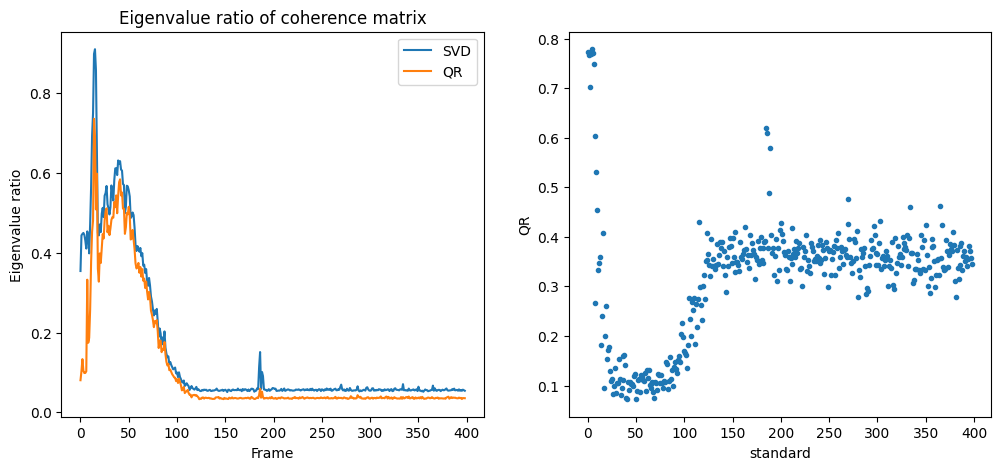

In [100]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(
    eig_ratios_coherence[1:400],
    label="SVD",
)
plt.plot(
    eig_ratios_coherence_qr[1:400],
    label="QR",
)
plt.xlabel("Frame")
plt.ylabel("Eigenvalue ratio")
plt.title("Eigenvalue ratio of coherence matrix")
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot((eig_ratios_coherence[1:400] - eig_ratios_coherence_qr[1:400]), ".")
plt.plot((eig_ratios_coherence[1:400] - eig_ratios_coherence_qr[1:400])/eig_ratios_coherence[1:400], ".")
plt.xlabel("standard")
plt.ylabel("QR")

Text(0.5, 0, '$\\frac{\\lambda_1 - \\overline{\\lambda_1}}{\\lambda_1}$')

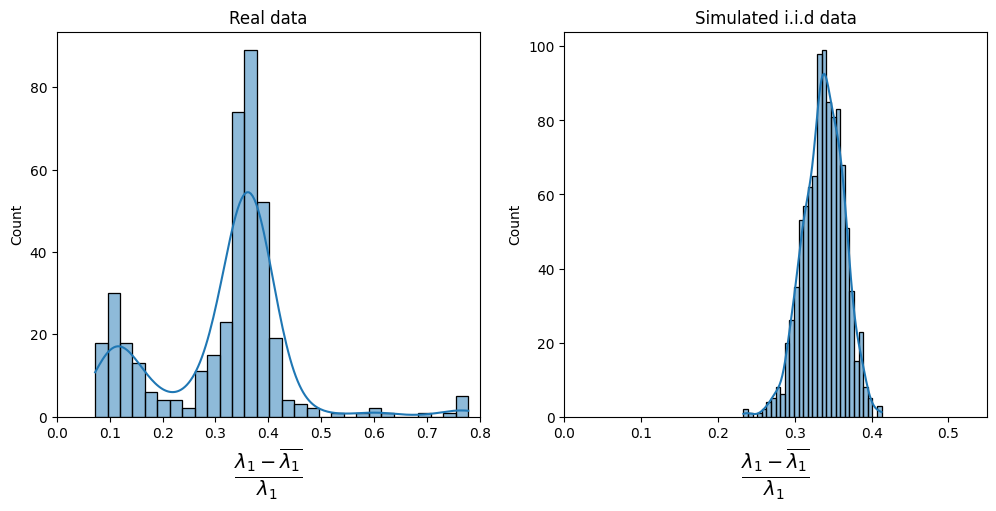

In [101]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot((eig_ratios_coherence[1:400] - eig_ratios_coherence_qr[1:400])/eig_ratios_coherence[1:400], kde=True, fill=True, alpha=0.5, bins=30)
plt.title("Real data")
plt.xlim([0, 0.8])
plt.xlabel(r"$\frac{\lambda_1 - \overline{\lambda_1}}{\lambda_1}$", fontsize=20)

plt.subplot(1, 2, 2)
sns.histplot((sim_eig_ratios_coherence[1:] - sim_eig_ratios_coherence_qr[1:])/sim_eig_ratios_coherence[1:], kde=True, fill=True, alpha=0.5, bins=30)
plt.title("Simulated i.i.d data")
plt.xlim([0, 0.55])
plt.xlabel(r"$\frac{\lambda_1 - \overline{\lambda_1}}{\lambda_1}$", fontsize=20)

Text(0.5, 0, '$\\frac{\\lambda_1}{\\max_i (d_i)}$')

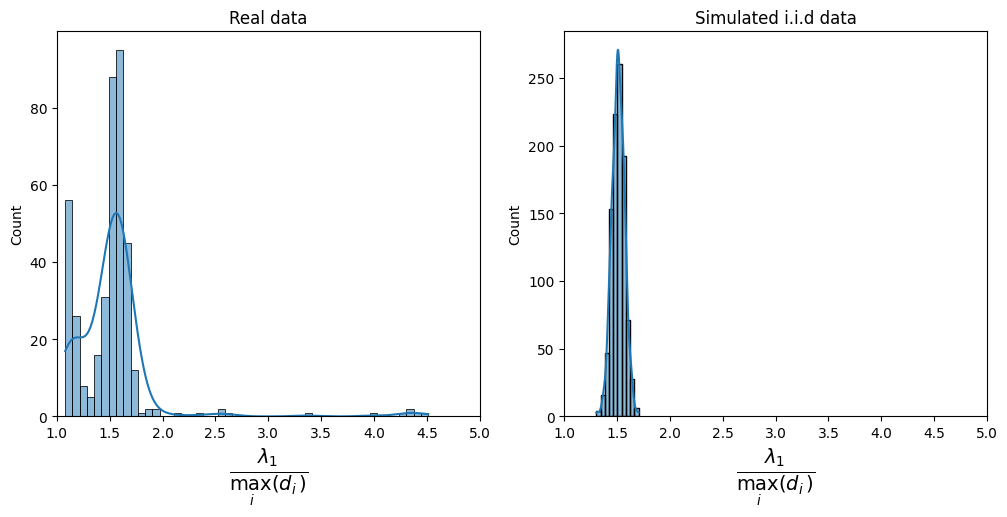

In [102]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot((eig_ratios_coherence[1:400])/eig_ratios_coherence_qr[1:400], kde=True, fill=True, alpha=0.5, bins=50)
plt.title("Real data")
plt.xlim([1, 5])
plt.xlabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=20)

plt.subplot(1, 2, 2)
sns.histplot((sim_eig_ratios_coherence[1:])/sim_eig_ratios_coherence_qr[1:], kde=True, fill=True, alpha=0.5, bins=10)
plt.title("Simulated i.i.d data")
plt.xlim([1, 5])
plt.xlabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=20)

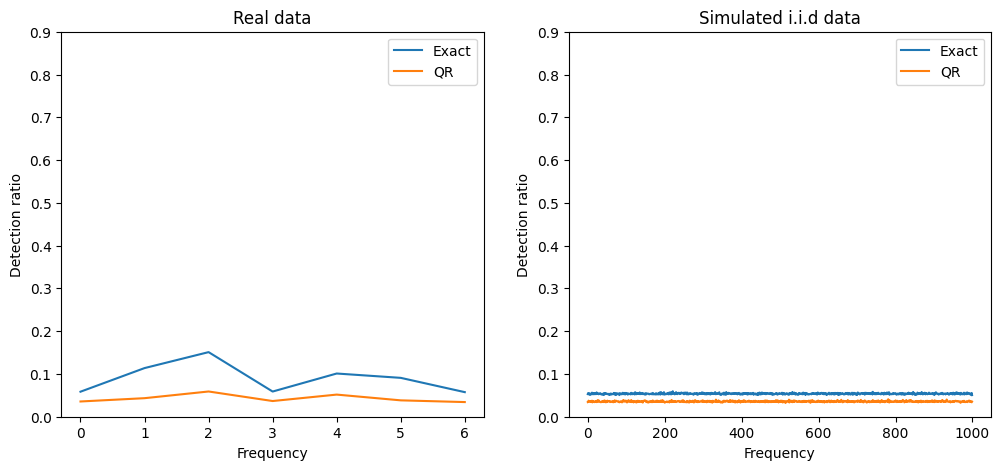

In [103]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(eig_ratios_coherence[185:192], label="Exact")
plt.plot(eig_ratios_coherence_qr[185:192], label="QR")
plt.title("Real data")
plt.ylabel("Detection ratio")
plt.xlabel("Frequency")
# plt.xlabel(r"$\frac{\lambda_1 - \overline{\lambda_1}}{\lambda_1}$", fontsize=20)
plt.ylim(0, 0.9)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sim_eig_ratios_coherence[1:], label="Exact")
plt.plot(sim_eig_ratios_coherence_qr[1:], label="QR")
plt.title("Simulated i.i.d data")
# plt.ylabel(r"$\frac{\lambda_1}{\sum \lambda_n}$", fontsize=20)
plt.ylabel("Detection ratio")
plt.xlabel("Frequency")
plt.ylim(0, 0.9)
plt.legend()
# plt.xlabel(r"$\frac{\lambda_1 - \overline{\lambda_1}}{\lambda_1}$", fontsize=20)

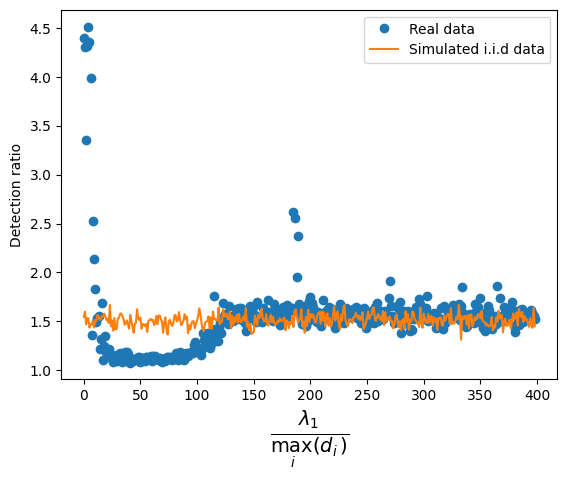

In [104]:
plt.plot((eig_ratios_coherence[1:400])/eig_ratios_coherence_qr[1:400], "o", label="Real data")
plt.plot((sim_eig_ratios_coherence[1:400])/sim_eig_ratios_coherence_qr[1:400], label="Simulated i.i.d data")
plt.xlabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=20)
plt.ylabel("Detection ratio")
plt.legend()

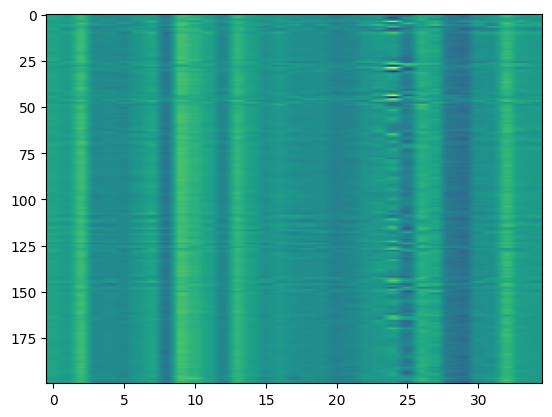

In [105]:
plt.imshow(norm_win_spectra[16].real, aspect="auto")

In [106]:
frequencies[16]

8.0

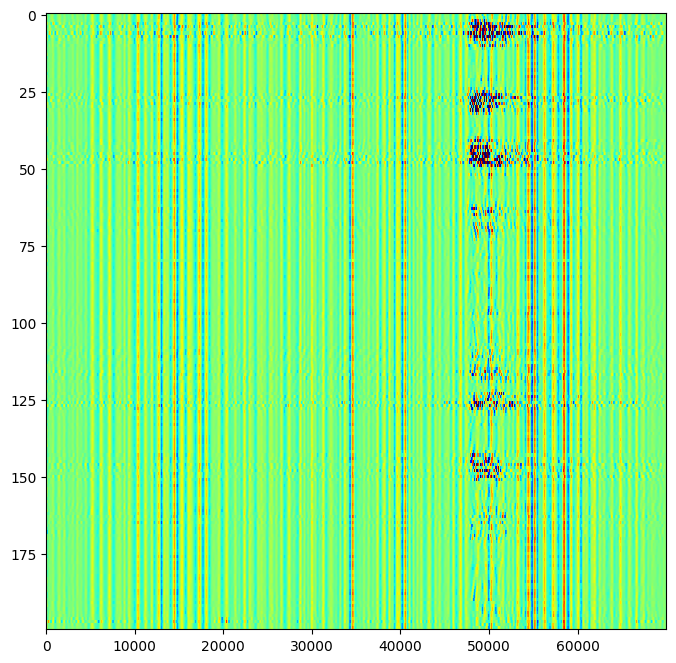

In [107]:
# filtered_data = f.frequency_filter(real_data, 6, "lowpass", 2, samples_per_sec)
# filtered_data = f.frequency_filter(real_data, 50, "highpass", 2, samples_per_sec)
filtered_data = f.frequency_filter(real_data, [6, 8], "bandpass", 2, samples_per_sec)
plt.figure(figsize=(8, 8))
plt.imshow(
    filtered_data,
    aspect="auto",
    interpolation="none",
    cmap="jet",
    vmin=-0.01,
    vmax=0.01,
    # extent=[0, 70000, 0, nsensors],
)

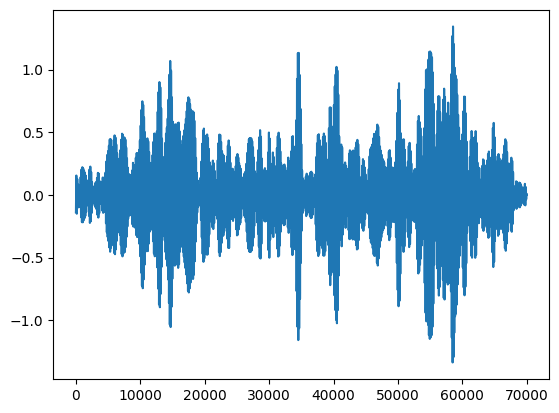

In [108]:
plt.plot(np.sum(filtered_data, axis=0), label="Filtered data")

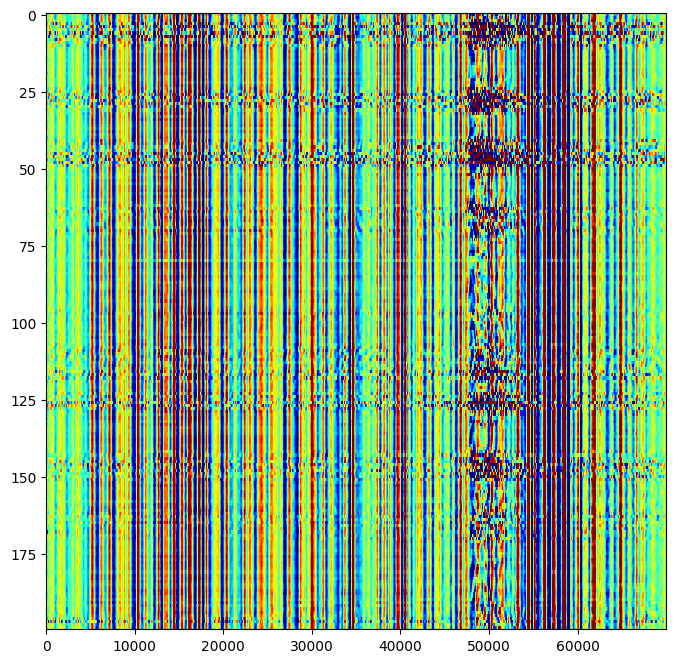

In [109]:
filtered_data = f.frequency_filter(real_data, [6, 9], "bandpass", 2, samples_per_sec)
# filtered_data = f.frequency_filter(real_data, 9, "lowpass", 2, samples_per_sec)
plt.figure(figsize=(8, 8))
plt.imshow(
    filtered_data,
    aspect="auto",
    interpolation="none",
    cmap="jet",
    vmin=-0.004,
    vmax=0.004,
    # extent=[0, 70000, 0, nsensors],
)